# EDA
## cleaning data: test에 없는 정보 삭제

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pickle
%matplotlib inline

df = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

c = df['DepartmentDescription'].isin(test['DepartmentDescription'])
c2 = df['Upc'].isin(test['Upc'])
c3 = df['FinelineNumber'].isin(test['FinelineNumber'])

# test에 없는 데이터 삭제
df = df[c&c2&c3]

# fill na: 여기서는 카테고리값 -> 임의로 "0.11 카테고리"로 지정
df['FinelineNumber'] = df['FinelineNumber'].fillna(0.11)
test['FinelineNumber'] = test['FinelineNumber'].fillna(0.11)

df['Upc'] = df['Upc'].fillna(0.11)
test['Upc'] = test['Upc'].fillna(0.11)

df['DepartmentDescription']= df['DepartmentDescription'].fillna(0.11)
test['DepartmentDescription'] = test['DepartmentDescription'].fillna(0.11)

In [22]:
#original
## test 중 df에 없는것
print(len(np.where(~np.isin(test['FinelineNumber'].unique(), df['FinelineNumber'].unique()))[0]))
## df 중 test에 없는것
print(len(np.where(~np.isin(df['FinelineNumber'].unique(), test['FinelineNumber'].unique()))[0]))

159
151


In [24]:
#original
## test 중 df에 없는것
## df 중 test에 없는것
print(len(np.where(~np.isin(test['FinelineNumber'].unique(), df['FinelineNumber'].unique()))[0]))
print(len(np.where(~np.isin(df['FinelineNumber'].unique(), test['FinelineNumber'].unique()))[0]))

322
0


In [20]:
#original
## test 중 df에 없는 것
print(len(np.where(~np.isin(test['Upc'].unique(), df['Upc'].unique()))[0]))
## df 중 test에 없는 것
print(len(np.where(~np.isin(df['Upc'].unique(), test['Upc'].unique()))[0]))

26980
26547


In [25]:
#original
## test 중 df에 없는 것
print(len(np.where(~np.isin(test['Upc'].unique(), df['Upc'].unique()))[0]))
## df 중 test에 없는 것
print(len(np.where(~np.isin(df['Upc'].unique(), test['Upc'].unique()))[0]))

26980
0


# 1. Basic DataFrame
## 구매수량, 방문요일, 방문코너 갯수, 환불횟수

In [3]:
frame_day = pd.get_dummies(df['Weekday'])
frame_day['VisitNumber'] = df['VisitNumber']
frame_day = frame_day.drop_duplicates('VisitNumber').set_index('VisitNumber')

frame_day_test = pd.get_dummies(test['Weekday'])
frame_day_test['VisitNumber'] = test['VisitNumber']
frame_day_test = frame_day_test.drop_duplicates('VisitNumber').set_index('VisitNumber')

np.where(frame_day.columns != frame_day_test.columns)

(array([], dtype=int64),)

In [5]:
frame_num_item = df.groupby('VisitNumber').agg(sum)['ScanCount']
frame_num_item_test = test.groupby('VisitNumber').agg(sum)['ScanCount']

len(frame_num_item), len(frame_num_item_test)

(93213, 95674)

In [7]:
df['v_dept'] = 1
test['v_dept'] = 1
frame_visit_num = df.groupby('VisitNumber').agg(sum)['v_dept']
frame_visit_num_test = test.groupby('VisitNumber').agg(sum)['v_dept']

len(frame_visit_num), len(frame_visit_num_test)

(93213, 95674)

In [25]:
df['return'] = 0
c = df['ScanCount'] < 0
df.loc[c, 'return'] = 1
frame_return = df[['VisitNumber', 'return']].drop_duplicates('VisitNumber').set_index('VisitNumber')

test['return'] = 0
c = test['ScanCount'] < 0
test.loc[c, 'return'] = 1
frame_return_test = test[['VisitNumber', 'return']].drop_duplicates('VisitNumber').set_index('VisitNumber')

len(frame_return), len(frame_return_test)

(93213, 95674)

- train

In [9]:
frame_day=frame_day\
.merge(frame_num_item, left_index=True, right_index=True)\
.merge(frame_visit_num, left_index=True, right_index=True)\
.merge(frame_return, left_index=True, right_index=True)

frame_day.to_pickle('frame_feature_basic.pkl')

- test

In [11]:
frame_day_test=frame_day_test\
.merge(frame_num_item_test, left_index=True, right_index=True)\
.merge(frame_visit_num_test, left_index=True, right_index=True)\
.merge(frame_return_test, left_index=True, right_index=True)

frame_day_test.to_pickle('frame_feature_basic_test.pkl')

# FinelineNumber PCA
## 5000 개 -> 1700 개로 축소

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
df_pivot = df.pivot_table(values='ScanCount', index='VisitNumber', columns='FinelineNumber').fillna(0)

df_pivot_test = test.pivot_table(values='ScanCount', index='VisitNumber', columns='FinelineNumber').fillna(0)
col = df_pivot.columns
df_pivot_test = df_pivot_test[col]

pca = PCA()
pca.fit(df_pivot)

array([0.91499434, 0.91509433, 0.91519404, ..., 1.        , 1.        ,
       1.        ])

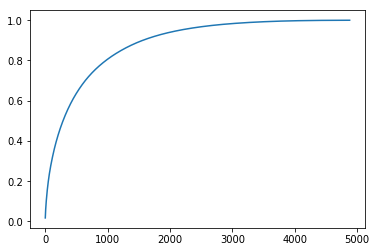

In [18]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
np.cumsum(pca.explained_variance_ratio_)[1700:]

In [ ]:
df_low = pca.transform(df_pivot)
col = ['f' + str(i) for i in range(n_com)]
idx = df_pivot.index
df_low = pd.DataFrame(df_low, index=idx, columns=col)
df_low.to_pickle('pca_fine_low.pkl')

In [ ]:
df_low_test = pca.transform(df_pivot_test)
col = ['f' + str(i) for i in range(n_com)]
idx = df_pivot_test.index
df_low_test = pd.DataFrame(df_low_test, index=idx, columns=col)
df_low_test.to_pickle('pca_fine_low_test.pkl')

# dept PCA
## 67개 -> 52개

In [ ]:
df_pivot = df.pivot_table(values='ScanCount', index='VisitNumber', columns='FinelineNumber').fillna(0)

df_pivot_test = test.pivot_table(values='ScanCount', index='VisitNumber', columns='FinelineNumber').fillna(0)
col = df_pivot.columns
df_pivot_test = df_pivot_test[col]

pca = PCA()
pca.fit(df_pivot)

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
np.cumsum(pca.explained_variance_ratio_)[1700:]

In [ ]:
df_low = pca.transform(df_pivot)
col = ['f' + str(i) for i in range(n_com)]
idx = df_pivot.index
df_low = pd.DataFrame(df_low, index=idx, columns=col)
df_low.to_pickle('pca_fine_low.pkl')

In [ ]:
df_low_test = pca.transform(df_pivot_test)
col = ['f' + str(i) for i in range(n_com)]
idx = df_pivot_test.index
df_low_test = pd.DataFrame(df_low_test, index=idx, columns=col)
df_low_test.to_pickle('pca_fine_low_test.pkl')

# Select fine by PFA(Principal Feature Analysis)
- 5000- > 972개 components로 extraction
- 원래 feature를 clustering, centroid에서 가까운 3개 추려냄

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

df_pivot = df.pivot_table(values='ScanCount', index='VisitNumber', columns='FinelineNumber').fillna(0)
pca = PCA()
pca.fit(df_pivot)

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
np.cumsum(pca.explained_variance_ratio_)

plt.axvline(972)
np.where(np.cumsum(pca.explained_variance_ratio_) > 0.8)

In [ ]:
# origian FinelineNumber는 components를 feature로 가지는 벡터가 됨
feat = df_pivot.columns
com = abs(pca.components_)
com = pd.DataFrame(com.T, index=feat)

In [ ]:
k = KMeans(n_clusters=972, random_state=1)
k.fit(com)
com['label'] = k.labels_

In [ ]:
# 각 클러스터의 중심을 찾음
center_dict = {label: np.array(vector) for vector, label in zip(k.cluster_centers_,range(972))}

In [ ]:
# 각 중심과 유클리디안 거리계산
def get_dist(row):
    label = row['label']
    center = center_dict[label]
    v1 = row.values[:-1]
    dist = np.linalg.norm(center-v1)
    return dist
com['dist'] = com.apply(get_dist, axis=1)

In [ ]:
# 각 클러스터에서 중심과 가까운 3개씩 feature select
selected = list(com.sort_values(['label', 'dist']).groupby('label').head(3).index)
with open('selected_fine.pkl', 'wb') as f:
    pickle.dump(selected, f)

- selected FinelineNumber로 df 생성

In [ ]:
with open('selected_fine.pkl', 'rb') as f:
    selected = pickle.load(f)
    
df1 = df.copy()
test1 = test.copy()

# 맨 처음에 na값을 0.11로 카테고리화 했으므로,
# 이번에는 0.12는 임의로 지정
c = ~df1['FinelineNumber'].isin(selected)
df1.loc[c, 'FinelineNumber'] = 0.12

c = ~test1['FinelineNumber'].isin(selected)
test1.loc[c, 'FinelineNumber'] = 0.12

# 정합성 체크
np.where(np.unique(test1['FinelineNumber'].unique()) != np.unique(df1['FinelineNumber'].unique()))

In [ ]:
# FinelineNumber 라벨 변경
lb_fine = LabelEncoder()
df1['FinelineNumber'] = lb_fine.fit_transform(df1['FinelineNumber'])
test1['FinelineNumber'] = lb_fine.transform(test1['FinelineNumber'])

# label fit
selected = lb_fine.transform(selected)

# 여기서 0은 카테고리가 아니라, value 0
df_pivot1 = df1.pivot_table(index='VisitNumber', columns='FinelineNumber', values='ScanCount', aggfunc=sum).fillna(0)
df_pivot_test1 = test1.pivot_table(index='VisitNumber', columns='FinelineNumber', values='ScanCount', aggfunc=sum).fillna(0)

df_pivot1 = df_pivot1[selected]
df_pivot_test1 = df_pivot_test1[selected]

np.where(df_pivot1.columns != df_pivot_test1.columns)

In [ ]:
frame_train_fine_pca = df_pivot1
frame_test_fine_pca = df_pivot_test1

# column 복원
frame_train_fine_pca.columns = lb_fine.inverse_transform(frame_train_fine_pca.columns)
frame_test_fine_pca.columns = lb_fine.inverse_transform(frame_test_fine_pca.columns)

np.where(frame_test_fine_pca.columns != frame_train_fine_pca.columns)

In [ ]:
frame_train_fine_pca.to_pickle('frame_fine_kmeans_uni.pkl')
frame_test_fine_pca.to_pickle('frame_fine_kmeans_uni_test.pkl')